In [1]:
import sys, os
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
root = os.getcwd()


from TwintDataMiner import TwintDataMiner
from PandasDataCleaner import PandasDataCleaner
from TextBlobSentiment import TextBlobSentiment
from Visualisation import Visualisation
from GMM import GMM


In [24]:
tweetsFile = "../data/final_location_tweets.csv"
tdm = TwintDataMiner()
attributes = ["id", "tweet", "place", "date"]
df = tdm.getPandasDataFrame(attributes, tweetsFile)
pdc = PandasDataCleaner()
df.shape
df.head
df = pdc.addGeneralLocation(df)

In [25]:

# df = df.groupby('genplace')['id'].nunique()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df)

In [26]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
"HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
"MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
"NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
df = df.loc[df['genplace'].isin(states)]

In [27]:
print(df.shape)
df = df.reset_index(drop=True)
df  = pdc.detectLanguage(df, 'tweet', 'lang')
df = pdc.cleanTweets(df, 'tweet')
print(df.head)
df = df.loc[df['lang'] == 'en']

print(df.shape)

(19971, 5)
Detecting language: 19970/19971<bound method NDFrame.head of                         id                                              tweet  \
0      1237392763848556549  How do you feel about #Coachella and #Stagecoa...   
1      1237392748426059791  #Coronavirus #COVID19 is a VIRUS - antibacteri...   
2      1237392735281115136  maybe the corona virus will finally give me th...   
3      1237392694084653056  @DougAndGator971 guys you dont know the true m...   
4      1237392669166276609  Bro they released Plague 8 years ago and someo...   
...                    ...                                                ...   
19966  1237166365087236096  State of Emergency Declared for Florida in Res...   
19967  1237166356900057089  @CNN Comes Out And Labels Coronavirus A Pandem...   
19968  1237166348687548416  Toilet paper isn't just for #Coronavirus anymo...   
19969  1237166322150256641  if you ever used the restrooms at 216,youre im...   
19970  1237166282543251456  #Trumpdem

In [28]:
saveddf = df.copy()
df = saveddf.copy()

In [29]:
df = saveddf.copy()
print(df.shape)

(18927, 6)


In [30]:
countDict = df.groupby('genplace').count()['id'].to_dict()
sorted_counted_states = (sorted( ((v,k) for k,v in countDict.items()), reverse=True))
enough_tweets_states=[]
for c,s in sorted_counted_states:
    #only include states with over 90 tweets
    if(c > 90):
        enough_tweets_states.append(s)
print(df.shape)
df = df.loc[df['genplace'].isin(enough_tweets_states)]

(18927, 6)


In [31]:
#hoax and science bag of words
vocab = ['conspiracy', '5g', 'fake', 'hoax', 'radiation', 'false', 'establishment', 'mainstream', 'media', 'poisoning', 'causes', 'brainwash', 'propaganda', 'disinformation', 'indoctrination', 'gates', 'planned', 'theory', 'science', 'policy', 'medical', 'logic', 'health', 'organisation', 'professional', 'professionals', 'journal', 'journals', 'medicine', 'biology', 'proof', 'proven', 'prove', 'scientist', 'scientists', 'brain', 'brains', 'system', 'academic', 'academics', 'study', 'studies', 'teach', 'teaching']
gmm = GMM()
bow = gmm.generateBagOfWords(df, 'tweet', vocab=vocab)
print(bow.shape)
print(np.sum(bow))

(18469, 44)
1622


In [32]:
state_bows = dict()
#max function to control noise
def maxi(x, amax):
    if(x > 0.005):
        ratio = x / amax
        x = 0.005 * ratio
    return x
def returnstate(place, state):
    if(state in place):
        return True
    return False
for state in enough_tweets_states:
    state_bows[state] = []
    #get dataframe of tweets from the state
    statedf = df[df['genplace'].apply(lambda x: returnstate(x, state))].copy()
    splitindex = int(statedf.shape[0] / 5)
    #split states tweets into groups
    for i in range(5):
        #get dataframe with tweets from group
        tempdf = statedf[i*splitindex:(i+1)*splitindex].copy()
        

        tempdf.sort_values("id", inplace=True)
    
        tempdf.drop_duplicates(subset=["tweet"],inplace=True) 
        tempdf = tempdf.reset_index(drop=True)

        bow = gmm.generateBagOfWords(tempdf, 'tweet', vocab=vocab)
        state_tweet_count = tempdf.shape[0]
        panicRow = np.sum(bow, axis=0)
        if(np.sum(panicRow)):
            #proportional bag of words
            panicRow = np.true_divide(panicRow, state_tweet_count)

            
            amax = np.amax(panicRow)            
            panicRow = np.array(list(map(lambda x: maxi(x, amax), panicRow)))
            state_bows[state] = state_bows[state] + [panicRow]
        else:
            #if all 0s then true_divide returns NaNs, so make vector with all zeros
            panicRow = np.zeros((44, ))
            state_bows[state] = state_bows[state] + [panicRow]
        

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
#remember which index in matrix is for which state
state_index_dict = dict()

bowMatrix = np.empty((1, len(vocab)), int)

index_count = 0
for state in enough_tweets_states:
    if(state in state_bows):
        state_index_dict[state] = []
        for i in range(5):
            bowMatrix = np.append(bowMatrix, np.reshape(state_bows[state][i], (1, len(vocab))), axis=0)
            state_index_dict[state] = state_index_dict[state] + [index_count]
            index_count += 1
#remove intialisation row
bowMatrix = np.delete(bowMatrix, (0), axis=0)

#hoax vector
controltweet1 = ['conspiracy 5g fake hoax radiation false establishment mainstream media poisoning causes brainwash propaganda disinformation indoctrination gates planned theory']
#non hoax vector
controltweet2 = ['science policy medical logic health organisation professional professionals journal journals medicine biology proof proven prove scientist scientists brain brains system academic academics study studies teach teaching']
count = CountVectorizer(vocabulary=vocab)
bag_of_words_bad = count.fit_transform(controltweet1)
bow_bad = bag_of_words_bad.toarray()
#apply maxi so control vectors dont skew data
bow_bad = np.array(list(map(lambda x: maxi(x, 0.4), bow_bad[0])))

bag_of_words_good = count.fit_transform(controltweet2)
bow_good = bag_of_words_good.toarray()

bow_good = np.array(list(map(lambda x: maxi(x, 0.4), bow_good[0])))

#add controls vectors to matrix
bowMatrix = np.append(bowMatrix, np.reshape(np.true_divide(bow_bad, 2), (1, len(vocab))), axis=0)
bowMatrix = np.append(bowMatrix, np.reshape(np.true_divide(bow_good, 2), (1, len(vocab))), axis=0)

print(bowMatrix.shape)
        

(192, 44)


0.00625
30.000000000000004
26.739936477553375
gaussian iteration
1 0


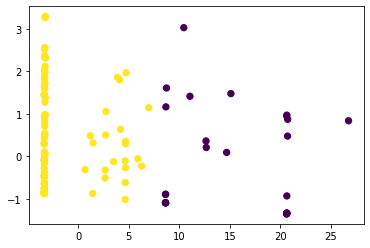

In [35]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

print(np.amax(bowMatrix))
#scale for pca
x = RobustScaler().fit_transform(bowMatrix)
print(np.amax(x))

pca = PCA(2)
x = pca.fit_transform(x)
print(np.amax(x))
correct = False
#keep making GMMs until control vectors are in different clusters
while(not correct):
    print("gaussian iteration")
    gmm = GaussianMixture(n_components=2, covariance_type='tied',  max_iter=10).fit(x)
    labels = gmm.predict(x)
    #probability of each class (e.g. panic and non-panic)
    panic = gmm.predict_proba(x)


    
    
    print(labels[-1], labels[-2])
    #check if control vectors are equal
    if(labels[-1] != labels[-2]):
        correct= True
        
        plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis')
        plt.show()

In [36]:
state_hoax_dict = dict()
for state in enough_tweets_states:
    #count groups classified as hoax sentiment
    state_hoax_count = 0
    for i in range(5):
        state_hoax_count += (labels[state_index_dict[state][i]] == labels[-2])
    state_hoax_dict[state] = state_hoax_count
    



In [37]:
#data on us elections
presdf = pd.read_csv('../data/1976-2016-president.csv')
plotarray = np.zeros((len(enough_tweets_states), 2))
for idx, state in enumerate(enough_tweets_states):
    #get trump vote share
    tempdf = presdf.loc[(presdf['year'] == 2016) & (presdf['state_po'] == state) & (presdf['candidate'] == 'Trump, Donald J.')]
    voteshare = (tempdf['candidatevotes'].iloc[0] / tempdf['totalvotes'].iloc[0]) * 100
    plotarray[idx, 0] = state_hoax_dict[state]
    plotarray[idx, 1] = voteshare

print(plotarray)

[[ 2.         31.61710654]
 [ 0.         52.23468558]
 [ 2.         32.39060231]
 [ 1.         49.02194142]
 [ 0.         51.68765068]
 [ 0.         38.76175307]
 [ 0.         48.5778858 ]
 [ 0.         32.28620279]
 [ 0.         41.35038665]
 [ 1.         50.77132605]
 [ 1.         60.72203369]
 [ 1.         48.67161647]
 [ 0.         49.8280947 ]
 [ 0.         33.90930473]
 [ 1.         44.42764701]
 [ 0.          4.07038311]
 [ 1.         36.83268019]
 [ 1.         47.49756422]
 [ 3.         58.08868465]
 [ 0.         56.94003345]
 [ 0.         45.50069532]
 [ 0.         43.25139737]
 [ 0.         56.77234784]
 [ 1.         62.08309236]
 [ 2.         65.32286482]
 [ 0.         45.54081659]
 [ 0.         44.9251931 ]
 [ 0.         40.92691438]
 [ 2.         54.93933269]
 [ 1.         39.09403518]
 [ 0.         47.21818457]
 [ 0.         62.51963855]
 [ 4.         56.65458181]
 [ 0.         51.16206134]
 [ 1.         58.74735113]
 [ 0.         60.57410216]
 [ 0.         57.94103809]
 

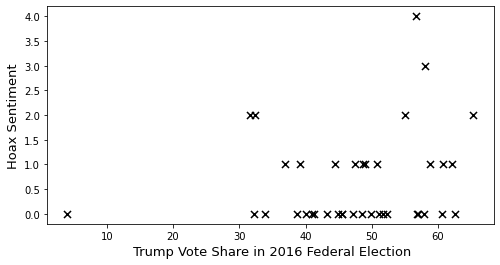

In [38]:

y = plotarray[:, 0]
z = plotarray[:, 1]
plt.figure(figsize=(8,4))
plt.scatter(z, y, s=50,color='black',marker='x',linewidths=1)
plt.xlabel(" Trump Vote Share in 2016 Federal Election", fontsize=13)
plt.ylabel("Hoax Sentiment", fontsize=13)
plt.show()

In [45]:
from scipy.stats import pearsonr
p, r = pearsonr(z, y)
print(p)

0.19412842484095727
